### Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_circles, make_regression
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
import random

In [2]:
# Реализуем класс узла
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [3]:
# Класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()        
        
    def predict(self):
              
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его        
        prediction = max(classes, key=classes.get)        
        return prediction

In [4]:
class RandomForest:
    
    def __init__(self, n_trees, min_leaf, criteria):
        self.n_trees = n_trees
        self.min_leaf = min_leaf
        self.criteria = criteria
             
        
    def info_criteria(self, labels):
        if self.criteria=='variance': 
            return np.mean((labels - np.mean(labels))**2) 
        #  подсчет количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        #  расчет критерия
        entropy_ = 0
        impurity = 1    
        for label in classes:
            p = classes[label] / len(labels)
            entropy_ -= p * np.log2(p)
            impurity -= p ** 2    

        if self.criteria == 'entropy':        
            return entropy_
        elif self.criteria == 'gini':
            return impurity
        
        
    # Расчет качества
    def quality(self, true_labels, false_labels, current_criteria):        
        # доля выбоки, ушедшая в левое поддерево
        p = float(true_labels.shape[0]) / (true_labels.shape[0] + false_labels.shape[0])
        return current_criteria - p * self.info_criteria(true_labels) - (1 - p) * self.info_criteria(false_labels)         
        
        
    # Разбиение датасета в узле
    def split(self, data, labels, index, t):

        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels
    
    
    def get_subsample(self, n_features):
        # будем сохранять не сами признаки, а их индексы
        sample_indexes = [i for i in range(n_features)]

        len_subsample = int(np.sqrt(n_features))
        subsample = []

        random.shuffle(sample_indexes)
        for _ in range(len_subsample):
            subsample.append(sample_indexes.pop())

        return subsample
        
        
    # Нахождение наилучшего разбиения
    def find_best_split(self, data, labels):

        current_criteria = self.info_criteria(labels)

        best_quality = 0
        best_t = None
        best_index = None        
        
        n_features = data.shape[1]
    
        # выбор индекса из подвыборки длиной sqrt(n_features)
        subsample = self.get_subsample(n_features)

        for index in subsample:
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < self.min_leaf or len(false_data) < self.min_leaf:
                    continue

                current_quality = self.quality(true_labels, false_labels, current_criteria)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index
                    
        return best_quality, best_t, best_index        
          
        
    # Построение дерева с помощью рекурсивной функции
    def build_tree(self, data, labels): 

        quality, t, index = self.find_best_split(data, labels)        

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == 0:
            return Leaf(data, labels)

        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)        

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels)
        false_branch = self.build_tree(false_data, false_labels)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева        
        return Node(index, t, true_branch, false_branch)
    
    
    
    def get_bootstrap(self, data, labels):
        n_samples = data.shape[0]
        bootstrap = []        
        ind_used = {}
        ind_not_used = {}
        for i in range(self.n_trees):
            b_data = np.zeros(data.shape)
            b_labels = np.zeros(labels.shape)            
            ind = []
            for j in range(n_samples):
                sample_index = random.randint(0, n_samples-1)
                ind.append(sample_index)
                b_data[j] = data[sample_index]
                b_labels[j] = labels[sample_index]                
                
            bootstrap.append((b_data, b_labels))
            ind_used[i] = list(set(ind))
            ind_not_used[i] = [j for j in range(n_samples) if j not in ind_used[i]]
        return bootstrap, ind_used, ind_not_used
 
         
    def fit(self, data, labels):
        forest = []
        bootstrap, ind_used, ind_not_used = self.get_bootstrap(data, labels)

        for b_data, b_labels in bootstrap:            
            forest.append(self.build_tree(b_data, b_labels))
            
        self.forest = forest
        self.index_used = ind_used
        self.index_not_used = ind_not_used
        
    
    def classify_object(self, obj, node):
        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)
        
        
    def predict_tree(self, data, tree):        
        classes = []
        for obj in data:
            prediction = self.classify_object(obj, tree)        
            classes.append(prediction)
        return classes
   
    
    def predict_with_OOB(self, data, pred_type='all'):
        # добавим предсказания всех деревьев в список
        predictions = []                   
        for i in range(self.n_trees):
            if pred_type == 'all':
                data_to_use = data
            else:
                if pred_type =='train':
                    ind = self.index_not_used[i]
                elif pred_type =='test':
                    ind = self.index_used[i]
                data_to_use = data.copy()
                data_to_use[ind] = np.nan
                
            predictions.append(self.predict_tree(data_to_use, self.forest[i]))
            
        # сформируем список с предсказаниями для каждого объекта
        predictions_per_object = list(zip(*predictions))

        # выберем в качестве итогового предсказания для каждого объекта то,
        # за которое проголосовало большинство деревьев
        voted_predictions = []
        for obj in predictions_per_object:
            voted_predictions.append(max(set(obj), key=obj.count))

        return voted_predictions    
        
       
    def predict(self, data, validate=False):
        if validate == False:
            return self.predict_with_OOB(data)
        else:
            return self.predict_with_OOB(data, 'train'), self.predict_with_OOB(data, 'test')

In [5]:

# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [6]:
# сгенерируем данные
classification_data, classification_labels = make_classification(n_samples=100 ,n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=42)

In [7]:
# Разобьем выборку на обучающую и тестовую
train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [8]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def RF_results(n_trees):    
    forest = RandomForest(n_trees, min_leaf=3, criteria='entropy')
    forest.fit(train_data, train_labels)

    train_answers = forest.predict(train_data)
    test_answers = forest.predict(test_data)

    train_accuracy = accuracy_metric(train_labels, train_answers)
    test_accuracy = accuracy_metric(test_labels, test_answers)
    

    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(forest.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    colors = ListedColormap(['red', 'blue'])
    light_colors = ListedColormap(['lightcoral', 'lightblue'])
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')
    plt.show()

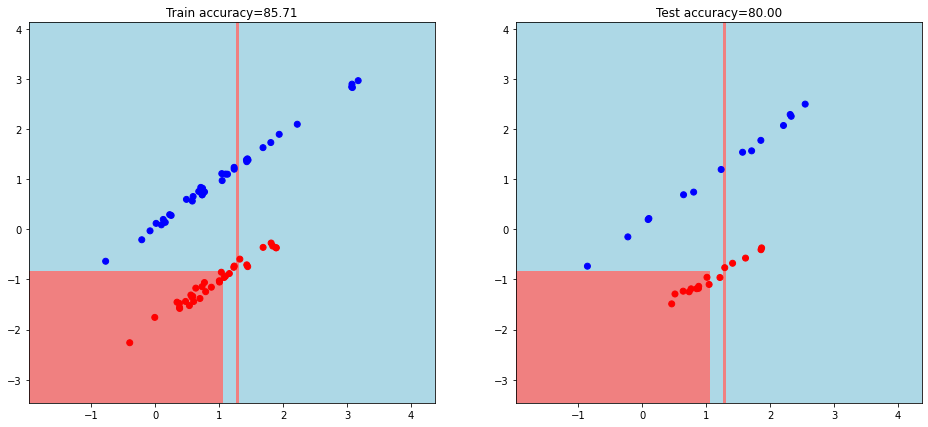

In [9]:
RF_results(1)

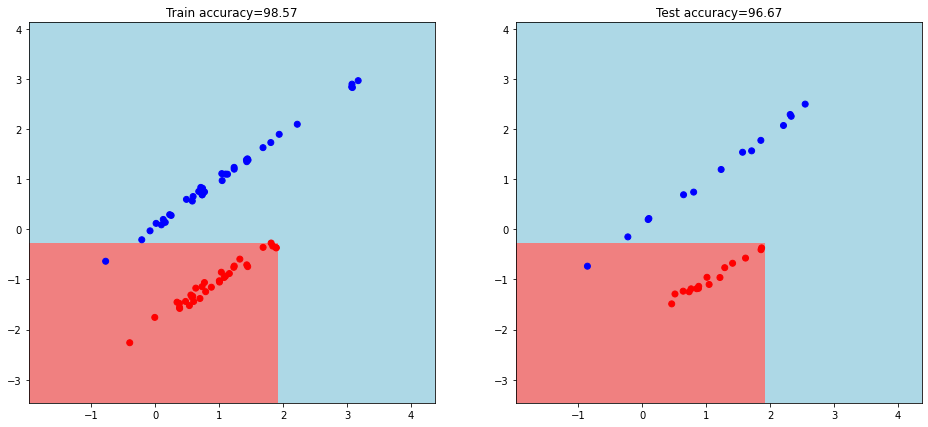

In [10]:
RF_results(3)

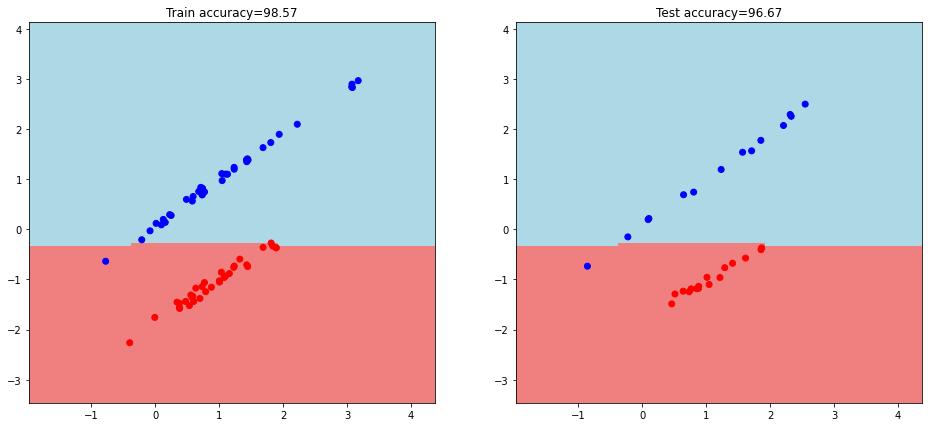

In [11]:
RF_results(10)

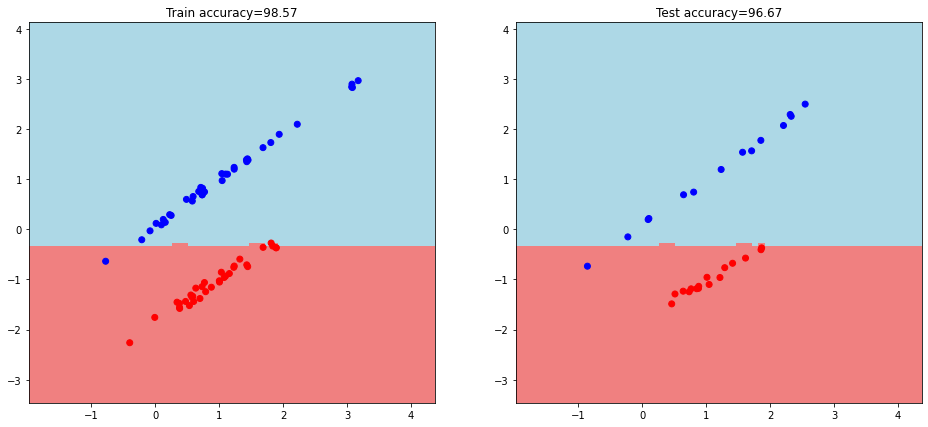

In [12]:
RF_results(50)

### Выводы
При большом количестве деревьев гиперплоскость не получается избыточно сложной. Случайный лес может быть недообучен, но из-за усреднения результатов он не переобучается с ростом количества деревьев в нем.